In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.50'

In [2]:
import numpy as np

from data import fits_image, data_1hour, data_pipeline
from catalogs import theoretical_sky
from interactive import *
from util import indices, rescale_quantile, gaussian_filter, circular_mask
from preprocessing import normalize, normalize_high, preprocess
from postprocessing import rotational_translational_component, integrate_2d_fourier, gradient

from flow import Flow

%matplotlib widget

%load_ext autoreload
%autoreload 2

/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


# Input Data and Preprocessing

In [3]:
image, psf, imwcs = data_1hour(0, order="freq")

In [4]:
sky = theoretical_sky(imwcs, psf, catalog="VLSSR", max_flux=10)

/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


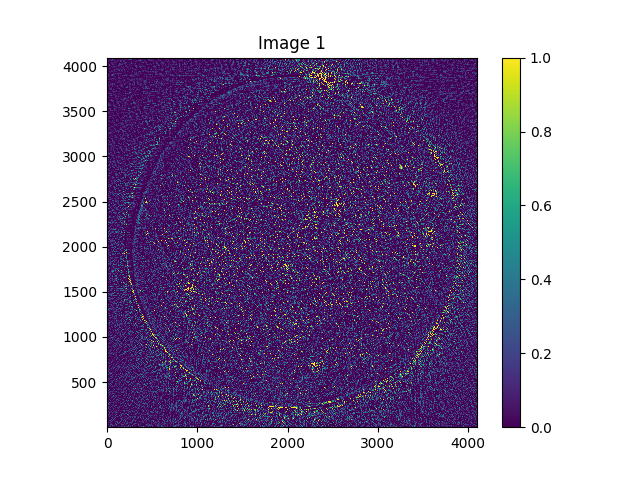

In [5]:
toggle_images(normalize_high(image), normalize_high(sky), name="inputs")

In [6]:
image_processed, sky_processed = preprocess(image, sky, weight=1.5)

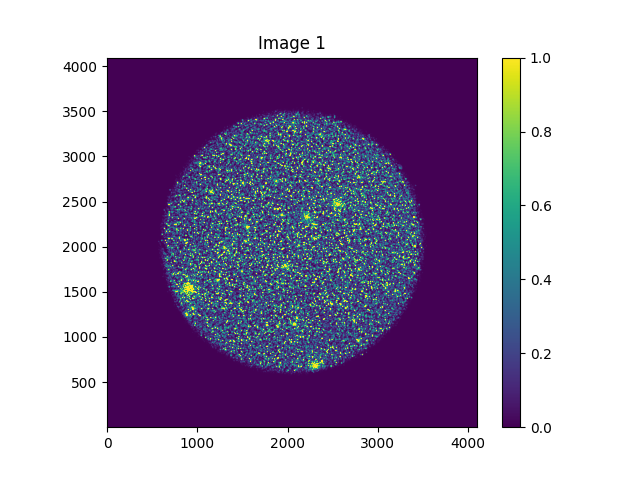

In [7]:
toggle_images(image_processed, sky_processed, name="processed")

# Core Flow Calculation

In [8]:
# apply gaussian to input images for a smoother output
flow = Flow.brox(image_processed, sky_processed, alpha=1.3, gamma=150, scale_factor=0.7)

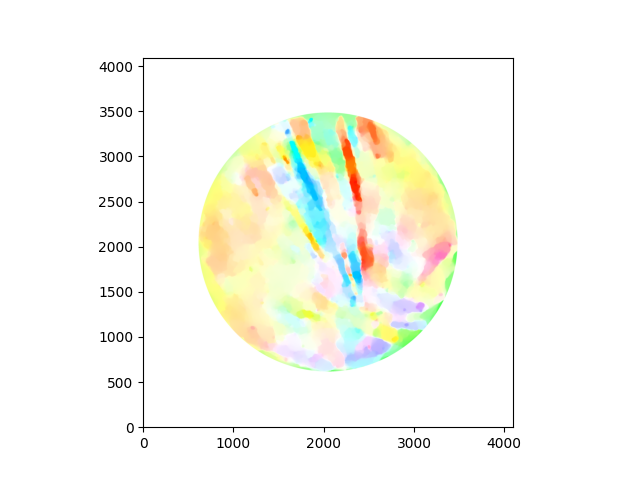

In [9]:
plot_flow(flow, scale=5, mask=circular_mask(r=0.7), name="flow")

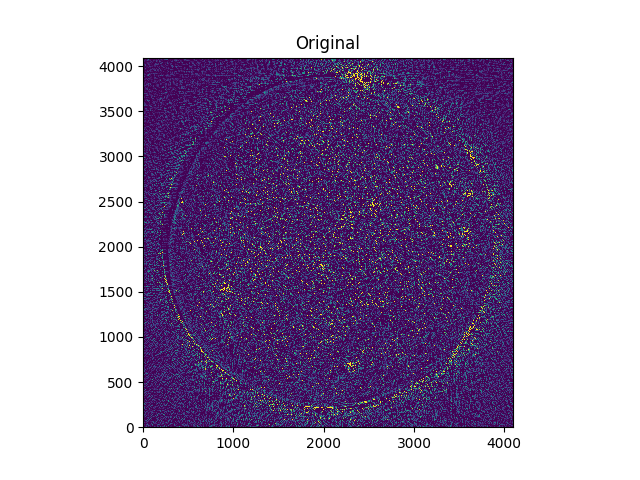

In [10]:
# press N and P to navigate to the next and previous images in the sequence, respectively.
sequence_images([
    normalize_high(image),
    flow.apply(normalize_high(image)),
    normalize_high(sky)
], titles=["Original", "Dewarped", "Theoretical"], name="dewarping")

# Various Postprocessing Steps

## Checking for rotational/translational components

In [11]:
flow_components = rotational_translational_component(
    jnp.array([1500, 2000]),
    flow.offsets,
    circular_mask(r=0.7)
)

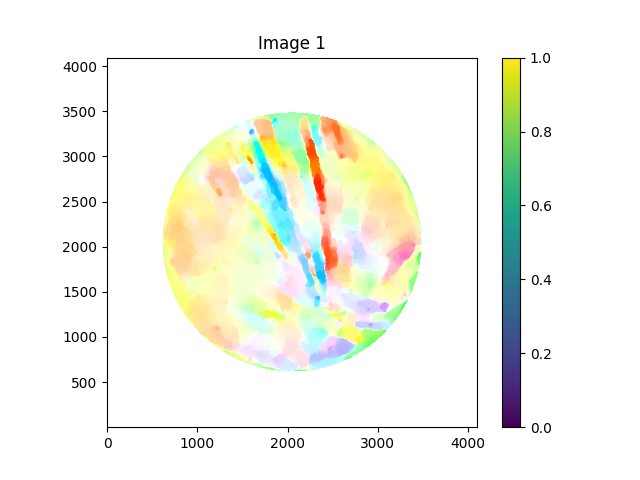

In [12]:
toggle_flow(flow, flow - flow_components, scale=5, mask=circular_mask(r=0.7), name="toggle_flow")

## Integrate flow to get relative TEC density

In [13]:
tec = integrate_2d_fourier(flow.offsets)

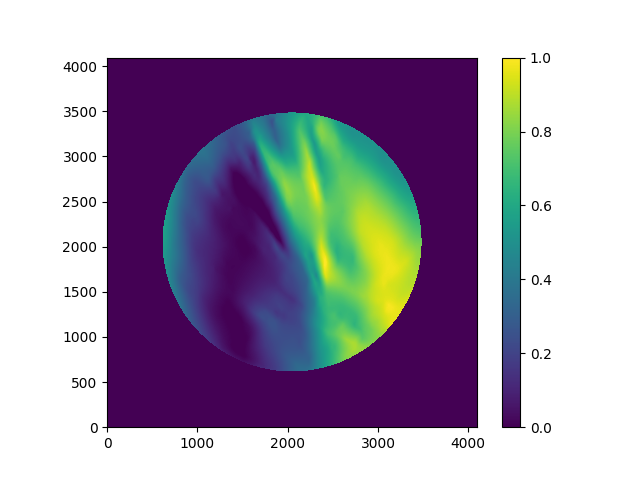

In [14]:
plot_image(normalize(tec) * circular_mask(r=0.7), name="tec")

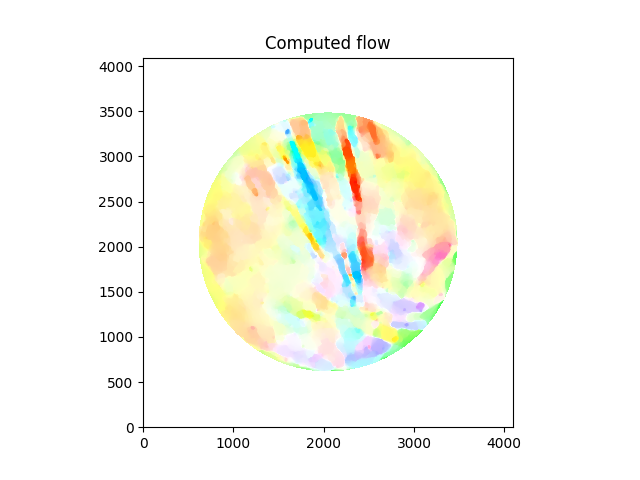

In [15]:
# check how well the gradient of the computed TEC matches up with the original flow field
sequence_images([
    flow.to_rgb(scale=5, mask=circular_mask(r=0.7)),
    Flow(gradient(tec)).to_rgb(scale=5, mask=circular_mask(r=0.7)),
    (flow - gradient(tec)).to_rgb(scale=5, mask=circular_mask(r=0.7)),
], titles=["Computed flow", "Gradient of integrated flow", "residual"], name="flow_seq"
)